![image](https://www.ewatercycle.org/img/logo.png)

## Case study 2: replace internal evaporation module of PCRGlobWB2.0 with external data source
This notebooks demonstrates how to use eWaterCycle to 'interfere' in a model. Every timestep, the evaporation of PCRGlobWB is 'corrected' to reflect the evaporation as measured by FLuxnet data. In this way, the model is forced by both precipitation and evaporation. Since we are only using one (point) measurement as 'the evaporation' of the entire basin, this (of course) leads to a rather different prediction for discharge. Which one is 'better' is, as always, in the eye of the beholder.

## Import statements
We'll be using the following modules

In [1]:
#OS related 
from os import environ, remove
from os.path import abspath
import os
from pathlib import Path
from glob import glob
from configparser import ConfigParser

#Time and time object related
import time
from datetime import datetime
from cftime import num2date

#calculations and plotting
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.io as sio
import xarray as xr
from scipy import optimize
from tqdm import tqdm

#cartography (drawing maps)
from cartopy.io import shapereader
from cartopy import crs

#hydrological specific non eWaterCycle
import hydrostats.metrics as hm
import hydrostats.visual as hv

#eWaterCycle specific
from ewatercycle.observation.grdc import get_grdc_data
from grpc4bmi.bmi_client_docker import BmiClientDocker

In [2]:
import pickle #this is only temporary, because we want to store output data at the end of a model run, so we can shut down the server if needed.

## functions needed

The following functions are needed for this experiment.

TO DO: all of these need to become part of libraries, or at least be moved to a supporting .py file that is imported above

In [1]:
from ewatercycle.util import (
    lat_lon_boundingbox_to_variable_indices,
    lat_lon_to_closest_variable_indices,
    var_to_xarray,
)

## List of files created for this experiment

### for PCRGlobWB2.0

- `merrimack_05min_era5.ini` This file is identical to the file with the same name used in the big comparison study. The only difference is that the time period (variables startTime and endTime) have been set to 2002-01-01 and 2002-12-31 respectivly. 



## Settings and parameters to run this experiment
The settings below are seperated in settings that 'belong' to the experiment, those that belong to PCRGlobWB or those that belong with MARRMoT

In [5]:
#Settings for this experiment

# The project home directory where data lives and output should be written
PROJECT_HOME = Path(os.path.abspath("/mnt/home/user42"))
DATA_HOME = Path(os.path.abspath("/mnt/data/examples/technical_paper"))

# Settings for GRDC station for final comparison of streamflow
station_id = '4147380' # GRDC station ID
basin_name = 'Merrimack'



In [6]:
#Settings for PCRGlobWB2.0
PCRGlob_input_dir=str(DATA_HOME / 'pcr-globwb' / 'input')
PCRGlob_Ref_output_dir=str(PROJECT_HOME / 'case2' / 'PCRGlobREFOutput')
PCRGlob_Exp_output_dir=str(PROJECT_HOME / 'case2' / 'PCRGlobExpOutput' + timeStamp.str + ensembleNr.str)
#forcing_dir = '/mnt/data/examples/technical_paper/pcr-globwb/input/'

PCRGlob_setting_file = str(PROJECT_HOME / 'technicalPaperExampleNotebooks' / 'settingFiles' 
                           / 'merrimack_05min_era5.ini')


In [ ]:
PCRGlob_Exp_output_dir.create()
PCRGlob_setting_file.copy(destination = PCRGlob_Exp_output_dir)

## Setting up the model objects

In [7]:
# start up a container for PCRGlob for the reference run 
# and initialize using the setting file
PCRGlob_Ref_model = BmiClientDocker(image='ewatercycle/pcrg-grpc4bmi:setters', image_port=55555,

                   input_dir=PCRGlob_input_dir,

                   output_dir=PCRGlob_Ref_output_dir)

 

PCRGlob_Ref_model.initialize(PCRGlob_setting_file.filename())

In [8]:
# start up a container for PCRGlob for the reference run 
# and initialize using the setting file
PCRGlob_Exp_model = BmiClientDocker(image='ewatercycle/pcrg-grpc4bmi:setters', image_port=55555,

                   input_dir=PCRGlob_input_dir,

                   output_dir=PCRGlob_Exp_output_dir)

 

PCRGlob_Exp_model.initialize(PCRGlob_setting_file)

In [9]:
#finally, create variables needed during the experiment run
PCRGlob_Ref_output = []
PCRGlob_Exp_output = []

PCRGlob_time_units = PCRGlob_Exp_model.get_time_units()

# importaing evaporation data from Fluxnet

In [10]:
#read the csv file downloaded from [TODO]
fluxnetData = pd.read_csv('FLX_US-Ha1_FLUXNET2015_SUBSET_DD_1991-2012_1-4.csv') #Read fluxnet data from exel
fluxnetData['Datetime']=pd.to_datetime(fluxnetData['TIMESTAMP'],format='%Y%m%d')
fluxnetData = fluxnetData.set_index('Datetime')

#Select evaporation measured as latent heat flux from fluxnetdata
#and rewrite evaporation from latent heat flux to m/day
fluxnetEvaporation = fluxnetData['LE_F_MDS'] / (2.43 * 1000000) * 6772 ** 2 / (3600 * 24) 


In [11]:
#Run the experiment PCRGlobWB model one timestep, store the output

#TODO: PCRGlobWB should be callable after .initialize() and now needs one .update() for 
# variables to be "get-able".

PCRGlob_Exp_model.update()
PCRGlob_Exp_output.append(var_to_xarray(PCRGlob_Exp_model, variable="discharge"))

## Running the experiment
With all pieces in place, we can now start to run the actual experiment. Since both models (reference and epxeriment) do not interact, they can be run in seperate loops and (ideally) this should be done in parallel.

In [21]:
#TODO (wish) this cell and the cell below have long runtimes, but are independent. Would be awesome of we could run in parallel.

print(f'Running Reference Model Run', flush=True)

#the experiment model is used as central 'time keeper'
while PCRGlob_Ref_model.get_current_time() < PCRGlob_Ref_model.get_end_time():
    
    #get the current time to print
    time = num2date(PCRGlob_Ref_model.get_current_time(), PCRGlob_time_units)
    print(f'Current time: {time}', end="\r")

    #run the reference model for one timestep, store the output
    PCRGlob_Ref_model.update()
    PCRGlob_Ref_output.append(var_to_xarray(PCRGlob_Ref_model, variable="discharge"))

print('')

Running Reference Model Run
Current time: 2002-12-30 00:00:00


In [22]:
print(f'Running Experiment', flush=True)

#TODO: PCRGlobWB has a bug where we can only get and set variables after at least one time step has been run, ie. 
# after the first .update().
#Run the experiment PCRGlobWB model one timestep, store the output
PCRGlob_Exp_model.update()
PCRGlob_Exp_output.append(var_to_xarray(PCRGlob_Exp_model, variable="discharge"))


#the experiment model is used as central 'time keeper'
while PCRGlob_Exp_model.get_current_time() < PCRGlob_Exp_model.get_end_time():
    
    #get the current time to print
    time = num2date(PCRGlob_Exp_model.get_current_time(), PCRGlob_time_units)
    print(f'Current time: {time}', end="\r")
    
    #After PCRGlob has calculated all states, extract the time from the model, than use that to determine the evaporation 
    # at that time according to Fluxnet. Calculate the correction needed as a correction.

    modelTimeAsDateTime = pd.to_datetime(num2date(PCRGlob_Exp_model.get_current_time(),PCRGlob_time_units).strftime())
    
    #get current from the model
    ussd = PCRGlob_Exp_model.get_value('upper_soil_saturation_degree')
    uss = PCRGlob_Exp_model.get_value('upper_soil_storage')
    lse = PCRGlob_Exp_model.get_value('land_surface_evaporation')
    bse = PCRGlob_Exp_model.get_value('bare_soil_evaporation') # Bare soil evaporation
    cs = PCRGlob_Exp_model.get_value('channel_storage') # channel storage
    
    #calculate corrections to model state
    #TODO line below should check / deal with devide by zero / NaN.
    muss =  (1 / ussd) * uss # maximum storage value of the upper soil layer
    mlse = np.nanmean(lse) # Mean land surface evaporation will be compared with the fluxnet measured evaporation
    flse = fluxnetEvaporation[modelTimeAsDateTime] / mlse
    abse = bse * flse # "Actual" bare soil evaporation
    cbse = abse - bse # correction bare soil evaporation
    csBU = cs #back up of channel storage

    
    #depending on the state of a given cell, determine how to apply the correction. If too much water would be added (exceding maximum soil capacity)
    # any excess is added to the chanel, ie. as direct runoff.
    for j in range(len(uss)):
        if uss[j] + cbse[j] > muss[j]:
            # The correction addition exeeds the maximum storage capacity in the upper soil layer for pixel j. 
            # The additional water is redirected to the channel storage.
            acs = (uss[j] + cbse[j]) - muss[j] # aditional channel storage
            cs[j] = cs[j] + acs #Edit the channel storage in pixel j
            uss[j] = muss[j] # Set the uppers soil storage for pixel j to maximum (the layer is full)

        elif uss[j] + cbse[j] < 0:
            # The correction addition reduces the storage capacity in the uppers soil layer to below zero.
            # A negative storage value is not possible therefore the (remaining) water deficit is taken from the channel storage.
            rfcs = (uss[j] + cbse[j]) # required from channel storage
            cs[j] = cs[j] + rfcs #Edit the channel storage for pixel j
            uss[j] = 0 #Edit the upper soil storage for pixel j to zero (the layer is empty)
           
        else:
            # If the correction additon does not put the value of the soil storage above or below its limits the correction flux is just added.
            uss[j] = uss[j] + cbse[j]
            

    
    cussd = uss / muss # Corrected upper soil saturation degree

    #correct NaN values
    for j in range(len(uss)):
        if np.isnan(cussd[j]):
            cussd[j] = ussd[j]
        if np.isnan(cs[j]):
            cs[j]=csBU[j]
            
    
    PCRGlob_Exp_model.set_value('upper_soil_saturation_degree', cussd) #After all the pixels have been corrected add the new saturation degrees to the model
    PCRGlob_Exp_model.set_value('channel_storage', cs) #After all the pixels have been corrected add the new channel storage to the model
    
    #Run the experiment PCRGlobWB model one timestep, store the output
    PCRGlob_Exp_model.update()
    PCRGlob_Exp_output.append(var_to_xarray(PCRGlob_Exp_model, variable="discharge"))
    

print('')

Running Experiment


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


### clean up after the model run
The models have to be 'finalized', which deletes any temporary files and the containers have to be shut down.

In [23]:

#before deleting the containers, get the start and end dates of the model run
# needed to select the right period from the GRDC Observations below


#TODO all date-time formats should be the same.
dstart = num2date(PCRGlob_Ref_model.get_start_time(),PCRGlob_time_units).strftime(format = '%Y-%m-%d')
dend = num2date(PCRGlob_Ref_model.get_end_time(),PCRGlob_time_units).strftime(format = '%Y-%m-%d')


PCRGlob_Ref_model.finalize()
PCRGlob_Exp_model.finalize()


del PCRGlob_Exp_model
del PCRGlob_Ref_model


In [24]:
f = open('.\..\modelrunCase2Full.pckl', 'wb')
pickle.dump([PCRGlob_Ref_output, PCRGlob_Exp_output],f)
f.close()
del f

## Import GRDC observations

Read the GRDC data for the period of the experiment, for the station given above. 
If you are not on jupyter.ewatercycle.org or cartesius, download the GRDC https://www.bafg.de/GRDC/EN/02_srvcs/21_tmsrs/riverdischarge_node.html and set the directory below in GRDC_DATA_HOME env var.

### TODO the four lines at the end of the cell should become part of the get_grdc_data function, which (I think) should return a dict.

In [25]:
#on Cartesius:
#environ['GRDC_DATA_HOME']= '/projects/0/wtrcycle/GRDC/GRDC_GCOSGTN-H_27_03_2019'

#on jupyter.ewatercycle.org
environ['GRDC_DATA_HOME']= '/mnt/data/grdc/dailies' 

#TODO 4 lines below should be one line
observations = get_grdc_data(station_id, start_date=dstart, end_date=dend)
grdc_obs = observations.to_dataframe().rename(columns = {'streamflow': 'GRDC'})
grdc_lon = observations.attrs['grdc_longitude_in_arc_degree']
grdc_lat = observations.attrs['grdc_latitude_in_arc_degree']

## Plot the results

In [26]:
f = open('.\..\modelrunCase2Full.pckl', 'rb')
data = pickle.load(f)
f.close()
del f

In [32]:
dataRef  = xr.concat(data[0], dim='time')
dataExp  = xr.concat(data[1], dim='time')

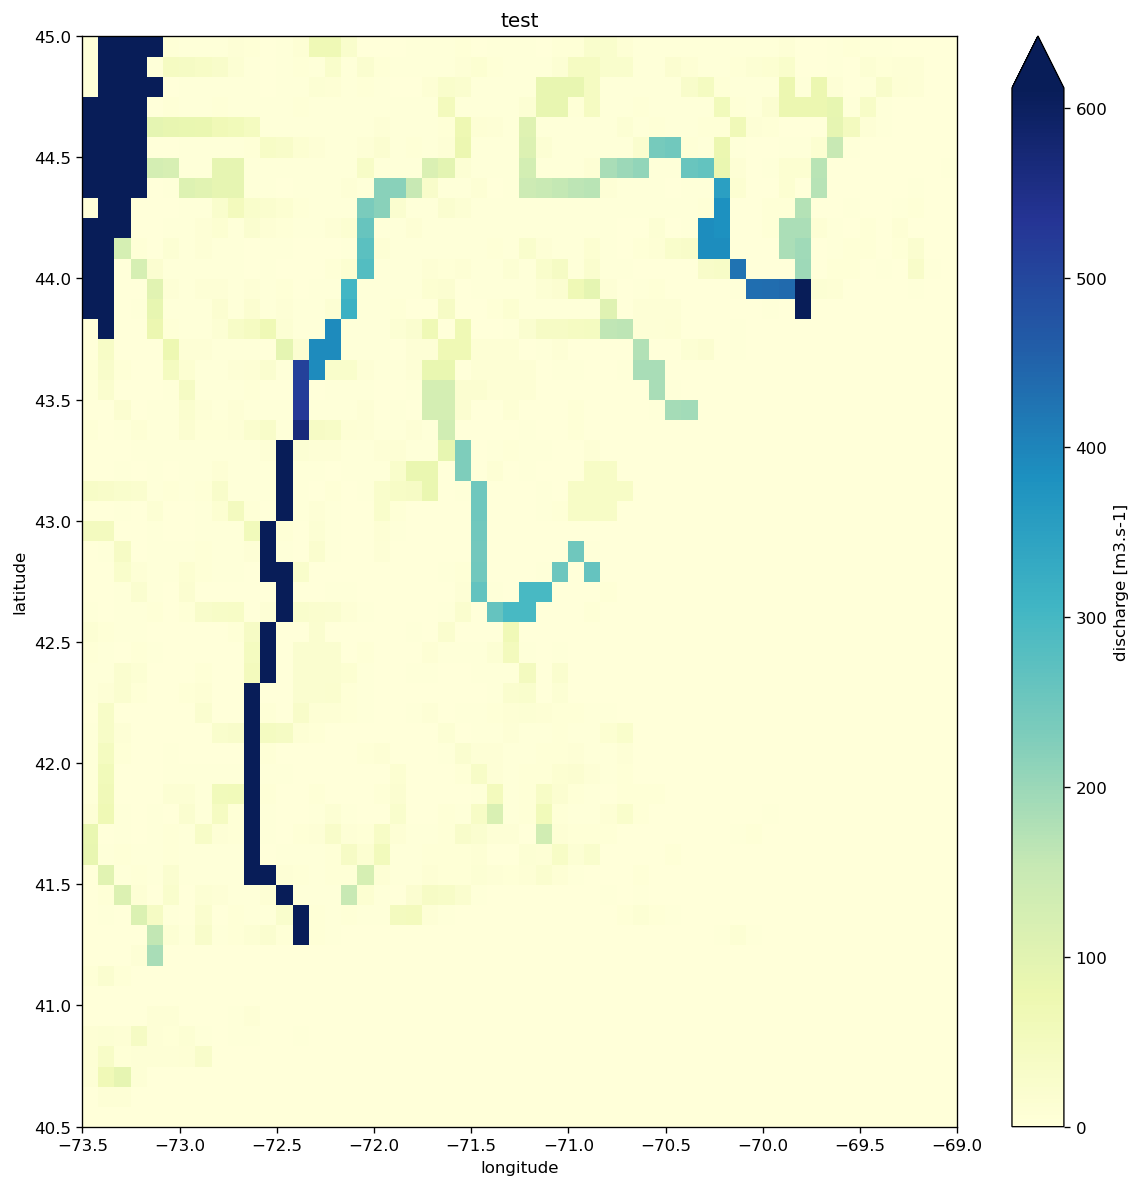

In [33]:
fig, axs = plt.subplots(1, 1, figsize=(10, 10), dpi=120)

dataExp.isel(time=-1).plot(ax=axs, cmap='YlGnBu', robust=True)
axs.set_title('test')
plt.tight_layout()
fig.savefig(f'pcrglobwb_RolfCase2_discharge_map', bbox_inches='tight', dpi=300)

In [34]:
pad=.2

# Write data for model output at GRDC location to pandas series,
# Use padding and max to correct for GRDC station location error
dataExpAtGRDCLocation = dataExp.sel(longitude=slice(grdc_lon-pad, grdc_lon+pad), 
                         latitude=slice(grdc_lat-pad, grdc_lat+pad)
                        ).max(['longitude', 'latitude']
                        ).rename('ERA5Exp'
                        ).to_dataframe()

dataExpAtGRDCLocation.index=dataExpAtGRDCLocation.index.to_datetimeindex()

dataRefAtGRDCLocation = dataRef.sel(longitude=slice(grdc_lon-pad, grdc_lon+pad), 
                         latitude=slice(grdc_lat-pad, grdc_lat+pad)
                        ).max(['longitude', 'latitude']
                        ).rename('ERA5Ref'
                        ).to_dataframe()

dataRefAtGRDCLocation.index=dataRefAtGRDCLocation.index.to_datetimeindex()



In [35]:
# Combine timeseries of ERA-Interim, ERA5 and GRDC observations in a pandas dataframe
df = pd.concat([dataExpAtGRDCLocation, dataRefAtGRDCLocation, grdc_obs],axis = 1)

# Note: the data come at different time stamps
print(df.head())

# For now, interpolating to get similar sets:
df = df.fillna(method='ffill').dropna()
print(df.head())

              ERA5Exp    ERA5Ref    GRDC
2002-01-01  71.991348  71.991348  56.067
2002-01-02  78.788757  78.788757  54.085
2002-01-03  79.178329  79.178329  48.988
2002-01-04  79.048172  79.046112  50.121
2002-01-05  78.262642  78.232491  47.572
              ERA5Exp    ERA5Ref    GRDC
2002-01-01  71.991348  71.991348  56.067
2002-01-02  78.788757  78.788757  54.085
2002-01-03  79.178329  79.178329  48.988
2002-01-04  79.048172  79.046112  50.121
2002-01-05  78.262642  78.232491  47.572


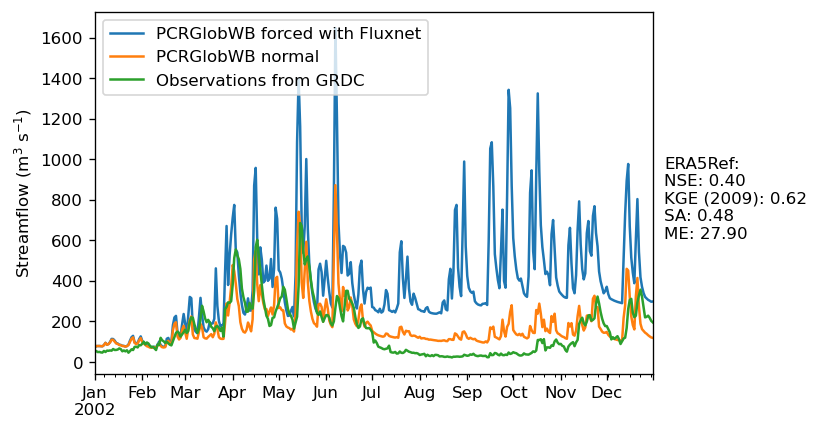

In [36]:
fig, ax = plt.subplots(dpi=120)
df.plot(ax=ax)
#ax.set_ylim(1000, 10000)
ax.set_ylabel('Streamflow (m$^3$ s$^{-1}$)')
ax.legend(['PCRGlobWB forced with Fluxnet','PCRGlobWB normal','Observations from GRDC'])

dataset='ERA5Ref'
yloc=0.6
ax.text(1.02, yloc, f"{dataset}:\n"
        f"NSE: {hm.nse(df[dataset], df['GRDC']):.2f} \n"
        f"KGE (2009): {hm.kge_2009(df[dataset], df['GRDC']):.2f}\n"
        f"SA: {hm.sa(df[dataset], df['GRDC']):.2f}\n"
        f"ME: {hm.me(df[dataset], df['GRDC']):.2f}",
        transform=ax.transAxes, va='top')

fig.savefig(f'pcrglobwb_{basin_name}_hydrograph', bbox_inches='tight', dpi=300)
